### 전이 학습으로 영화 리뷰 텍스트의 감성 분류하기 목차
* [Chapter 1 트랜스포머 인코더 기반 언어 이해 모델 - BERT)](#chapter1)
* [Chapter 2 KerasNLP로 영화 리뷰 텍스트의 감성 분류하기](#chapter2)
* [Chapter 3 KerasNLP 미세튜닝](#chapter3)
* [Chapter 4 텍스트 전처리하기 - BERT 토크나이져](#chapter4)
* [Chapter 5 허깅페이스로 영화 리뷰 텍스트의 감성 분류하기](#chapter5)

### Chapter 1 트랜스포머 인코더 기반 언어 이해 모델 - BERT <a class="anchor" id="chapter1"></a>
1. BERT(Bidirectional Encoder Representations from Transformers)
   - 구글이 2018년에 발표한 트랜스포머 인코더 기반의 대규모 언어모델(LLM Large Language Model)
   - 이전 모델들이 한 방향으로만 단어를 이해한 것과 달리, 단어의 양방향 문맥을 동시에 학습
   - 대규모 텍스트 데이터를 활용해 사전 학습을 수행한 뒤, 다양한 자연어 처리 작업에 쉽게 적용 할 수 있는 범용 모델로 설계
   - 두 가지 사전 훈력 방식 사용
      - 입력 데이터의 일부 토큰을 가린(마스킹Masking)다음, 모델이 가려진 단어를 예측하는 마스크드 언어 모델링(MLM Masked Language Modeling)
      - 두 문장이 제시됐을 때 두 번재 문장이 첫번째 문장에 이어지는 다음 문장인지를 예측하는 다음 문장 예측(NSP Next Sentence Prediction)
2. 자연어 처리 모델에서는 학습된 출력 벡터를 기반으로 수행되는 별도의 분류기를 제외한 다른 나머지 부분들을 조종 백본(Backbone) 또는 베이스(base)라고 부른다.
3. BERT 모델은 여러 개의 트랜스포머 인코더 블록을 포함하고 있는 BERT 백본과 분류기로 구성되어있다.
   - 입력 구성
      - 가장 왼쪽의 입력은 세 가지 임베딩을 더해 구성된다.
         - 다음 문장 예측(NSP) 작업을 위해 두 개의 문장을 구분하여 입력
         - 세그먼트 임베딩: 각 토큰이 두 개의 문장 중 어디에 속하는지 구분을 위해 각 단어에 문장 1 또는 문장 2임을 나타내는 정보를 추가
         - 토큰 임베딩: 각 단어를 고정된 길이의 벡터로 변환
         - 위치 임베딩: 문장 내 단어의 순서를 나타내는 위치 정보를 추가
   - 트랜스포머 인코더 블록
      - BERT 백본의 핵심은 반복적으로 쌓아 올린 트래스포머 인코더이다.
      - 멀티 헤드 어텐션, 피드 포워드 네트워크, 층 정규화로 구성된다.
      - 여러 개의 트랜스포머 인코더 블록을 거쳐 처리된 출력은 tanh 활성화 함수를 가진 밀집층을 통화한다.
   - 분류기
      - 주어진 문제의 클래스 개수만큼 출력을 만들어 분류 작업을 수행한다.

    ![BERT](image/04-02-BERT.png)   

    4. GELU(Gaussian Error Linear Unit)
       - OpenAI GPT 모델에서 사용되는 활성화 함수
       - 입력 값 x에 표준 정규 분포의 누적 분포 함수(CDF Cumulative Distribution Function)를 곱해 출력
       - 수식: x * P(X <= x) = x * 0.5(1 + tanh[sqrt(2/pi)(x + 0.044715x^3)])
       - ReLU와 유사하지만, 입력이 음수일 때도 작은 값을 출력
       - 입력이 음수일 때도 작은 값을 출력하기 때문에 ReLU보다 더 부드러운 곡선을 가진다.
       - BERT 모델에서는 GELU가 ReLU보다 더 나은 성능을 보인다.

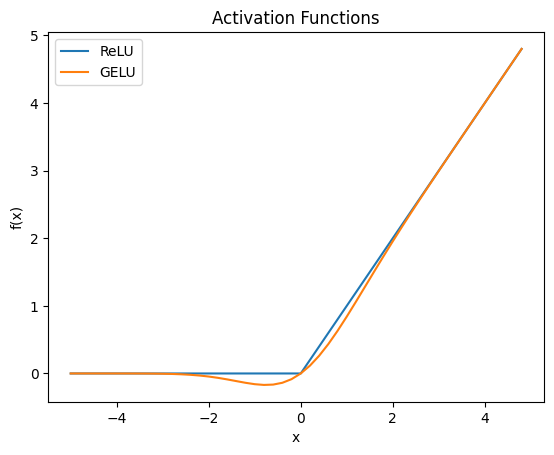

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

def gelu(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

# GELU 함수 시각화
# 0.2 간격으로 -5~5 구간의 값 생성
x = np.arange(-5, 5, 0.2)

# 그래프 그리기
# x축: x, y축: clip(0)와 gelu(x)
plt.plot(x, x.clip(0), label='ReLU') # ReLU 함수
plt.plot(x, gelu(x), label='GELU') # GELU 함수
plt.legend()
plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [4]:
import keras_nlp

# BERT base 모델 규격 
vocab_size = 30522 # BERT base 모델의 단어 집합 크기=
num_layers = 12 # BERT base 모델의 인코더 층 수
num_heads = 12 # BERT base 모델의 멀티 헤드 어텐션 헤드 수
hidden_dim = 768 # BERT base 모델의 숨겨진 차원 수
dropout = 0.1 # BERT base 모델의 드롭아웃 비율
activation = 'gelu' # BERT base 모델의 활성화 함수
max_seq_len = 512 # BERT base 모델의 최대 시퀀스 길이

2025-10-04 12:04:09.414827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759547049.430041    5967 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759547049.435053    5967 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759547049.449147    5967 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759547049.449170    5967 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759547049.449172    5967 computation_placer.cc:177] computation placer alr

In [5]:
import keras 
from keras import layers

def transformer_encoder(x, padding_mask, dropout, activation='relu'):
     residual = x
     key_dim = hidden_dim // num_heads
     
     # 배치에 있는 샘플 시퀸스 길이가 다른 경우, 짧은 시퀴스에 0 패딩을 추가하여 동일하게 맞춤
     # padding_mask: 0 패딩을 무시하기 위해 1과 0으로 이루어진 마스크
     x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query=x, value=x, attention_mask=padding_mask)
     
     # 잔차 드롭아웃: 스킵 연결 직전에 통과하는 드롭아웃 층
     x = layers.Dropout(dropout)(x)
     
     # 스킵 연결: 입력을 출력에 더해줌
     x = x + residual
     x = layers.LayerNormalization()(x)
     residual = x
     
     # 두 개의 밀집층으로 이루어진 피드 포워드 신경망
     x = layers.Dense(hidden_dim * 4, activation=activation)(x)
     x = layers.Dense(hidden_dim)(x)
     x = layers.Dropout(dropout)(x)
    
     x = x + residual
     x = layers.LayerNormalization()(x)
     return x

In [6]:
import keras 
from keras import layers

# 입력층 토큰, 세크먼트, 패딩 마스크
token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

# 토큰 입력을 사용해 토큰 임베딩, 위치 임베딩, 세그먼트 임베딩 생성
token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)

# 위치 임베딩 - 삼각함수 대신 위치 임베딩 층을 사용해 위치 임베딩 생성
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

# 세그먼트 임베딩 - 다음 문장 예측을 위해 입력되는 문장의 개수가 두 개이므로 크기는 2
segment_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

# 토큰 임베딩, 위치 임베딩, 세그먼트 임베딩을 더하고 층 정규화와 드롭아웃 적용
x = layers.Add()([token_embedding, pos_embedding, segment_embedding])
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

# BERT base 모델은 12개의 트랜스포머 인코더 층을 쌓음
for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

# 트랜스포머 인코더 출력의 첫 번째 토큰에 분류 작업에 대한 결과가 저장되어 있다.
#   - 밀집층을 호출 할 때 x[:, 0, :]로 첫 번째 토큰의 출력만 선택
outputs = layers.Dense(hidden_dim, activation='tanh')(x[:, 0, :]) 
model = keras.Model([token_ids, segment_ids, padding_mask], outputs)
model.summary()

I0000 00:00:1759547068.908552    5967 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5555 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 768) │ 23,440,896 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    393,216 │ embedding[0][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 768) │      1,536 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding[0][0],  │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 109,482,240 (417.64 MB)

 Non-trainable params: 0 (0.00 B)

### Chapter 2 KerasNLP로 영화 리뷰 텍스트의 감성 분류하기 <a class="anchor" id="chapter2"></a>
1. KerasNLP에서 제공하는 BERT 모델을 사용해 IMDB 영화 리뷰 데이터셋의 감성 분류 작업을 수행할 수 있다.

In [9]:
# 구글 드라이브에있는 IMDB 데이터셋 다운로드 및 압축 해제
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=05f5f66d-24e2-4e4e-8d60-426f26426a21
To: /home/redinblue/hongong-study-deeplearning/aclImdb_v1.tar.gz
100%|██████████████████████████████████████| 84.1M/84.1M [00:03<00:00, 24.4MB/s]


In [11]:
import keras 
# "aclImdb/train" 하위 데이터를 80%는 훈련 데이터, 20%는 검증 데이터로 분리
# subset="both"  훈련데이터화 검증데이터 둘다 반환
train_ds, val_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=32,
    validation_split=0.2,
    subset="both",
    seed=42
)

# 테스트 데이터셋 로드
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [12]:
# 훈련 데이터셋의 샘플 1개 출력
#   - unbatch(): 배치 차원을 제거해 데이터셋을 샘플 단위로 변환
#   - take(1): 데이터셋에서 샘플 1개 선택
#   - get_single_element(): 선택한 샘플을 (특징, 레이블) 튜플로 반환
feature, target = train_ds.unbatch().take(1).get_single_element()
print(feature.numpy()[:100])  # 100자만 출력

# 특징 : 부정적인 감성의 텍스트 - 'Pandemonium'은 공포 영화의 패러디로, 웃기기 보다는 멍청하게 느껴집니다. 제가 말하는 걸 믿으세요
#   - b'...' : 바이트 문자열
# 레이블 : 0 (부정적인 감성)
print(target.numpy()) 

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell '
0


In [13]:
import keras_nlp

# KerasNLP에서 제공하는 백본 모델과 토크나이저, 분류기를 합친 BertClassifier를 사용해 BERT 모델 생성
#   - 토크나이저 : 텍스트를 모델에 입력할 때 먼저 모델이 이해할 수 있는 형식으로 텍스트를 변환하는 작업
#   - from_preset() : 사전 훈련된 BERT 모델과 토크나이저, 분류기를 한번에 생성
#   - num_classes=2 : 긍정과 부정을 구분하는 이진 분류 작업
#   - bert_tiny_en_uncased : 영어 소문자 전용 BERT Tiny 모델
classifier = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased", num_classes=2)


100%|██████████| 454/454 [00:00<00:00, 1.00MB/s]


100%|██████████| 16.8M/16.8M [00:02<00:00, 6.77MB/s]


100%|██████████| 761/761 [00:00<00:00, 2.35MB/s]


100%|██████████| 226k/226k [00:00<00:00, 236kB/s]


In [16]:
import keras
import tensorflow as tf
import keras_nlp
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


#Keras version: 3.6.0
#TensorFlow version: 2.18.1
#Keras NLP version: 0.21.1

# conda create -n CUDA7 python=3.9 
# activate CUDA7
# conda install -c anaconda keras
# pip install keras-nlp

print("Keras version: "+keras.__version__)
print("TensorFlow version: "+tf.__version__)
print("Keras NLP version: "+keras_nlp.__version__)
print(device_lib.list_local_devices() )




Keras version: 3.11.3
TensorFlow version: 2.19.1
Keras NLP version: 0.22.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11898633311053326557
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5824839680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17324134942630678712
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1759547402.834940    5967 gpu_device.cc:2019] Created device /device:GPU:0 with 5555 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


### Chapter 3 KerasNLP 미세튜닝 <a class="anchor" id="chapter3"></a>
1. BertClassfier에 포함된 백본 모델은 훈련이 가능하다

2. 미세튜닝(Fine-tuning)
   - 사전 훈련된 모델을 특정 작업에 맞게 추가로 훈련하는 과정
   - 사전 훈련된 모델의 가중치를 초기값으로 사용하고, 새로운 데이터셋에 대해 모델을 다시 훈련
   - 미세튜닝은 일반적으로 사전 훈련된 모델의 가중치를 크게 변경하지 않고, 새로운 작업에 적응시키는 데 중점을 둔다.
   - 미세튜닝은 일반적으로 더 적은 양의 데이터와 더 짧은 훈련 시간으로도 좋은 성능을 얻을 수 있다.
   - 미세튜닝은 전이 학습(Transfer Learning)의 한 형태로 간주될 수 있다.

In [ ]:
# sparse_categorical_crossentropy : 레이블이 원-핫 인코딩이 아닌 정수인 경우 사용
classifier.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


I0000 00:00:1759547643.159565    6389 service.cc:152] XLA service 0x76fe7008a870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759547643.159598    6389 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-10-04 12:14:03.283217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759547643.892093    6389 cuda_dnn.cc:529] Loaded cuDNN version 91301
2025-10-04 12:14:05.690650: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 432 bytes spill stores, 336 bytes spill loads

2025-10-04 12:14:05.701297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50

  7/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.5256  

I0000 00:00:1759547658.134351    6389 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5729 - sparse_categorical_accuracy: 0.6869

2025-10-04 12:14:34.012080: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15_0', 52 bytes spill stores, 52 bytes spill loads

2025-10-04 12:14:34.146287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 160 bytes spill stores, 160 bytes spill loads

2025-10-04 12:14:34.211598: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15', 432 bytes spill stores, 336 bytes spill loads

2025-10-04 12:14:34.282022: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 388 bytes spill stores, 388 bytes spill loads

2025-10-04 12:14:34.323585: I external/l

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - loss: 0.4689 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.8460
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.2952 - sparse_categorical_accuracy: 0.8796 - val_loss: 0.3022 - val_sparse_categorical_accuracy: 0.8736
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.2828 - val_sparse_categorical_accuracy: 0.8836
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.3623 - val_sparse_categorical_accuracy: 0.8644
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.9542 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8758


In [18]:
# 이진 분류 문제이므로 마지막 Dense층의 유닛이 하나만 있어도된다.
classifier = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased", num_classes=1, activation="sigmoid")    

In [19]:
# compile() 메서드를 통해 필요한 설정을 변경할 수 있다
# RMSprop 옵티마이져 : 적응적 학습률 방법으로, 각 매개변수에 대해 개별 학습률을 유지
#   - 학습률이 너무 크면 발산하고, 너무 작으면 수렴이 느려지는 문제를 해결
#   - 학습률을 자동으로 조정하여 훈련을 안정화하고 가속화
#   - 학습률 0.001로 설정
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)

# compile() 메서드를 통해 필요한 설정을 변경할 수 있다
# binary_crossentropy : 이진 분류 문제에 사용
# metrics=['accuracy'] : 훈련과 평가 과정에서 모델의 정확도를 모니터링
classifier.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

# 조기 종료 콜백 : 검증 손실이 3회 연속 개선되지 않으면 훈련을 중단하고, 가장 성능이 좋았던 모델의 가중치를 복원
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 미세튜닝을 위해 에포크 수를 20으로 늘리고, 조기 종료 콜백을 추가
# 20 에포크 동안 훈련을 시도하지만, 검증 손실이 3회 연속 개선되지 않으면 훈련을 중단
hist = classifier.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping_cb])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 105ms/step - accuracy: 0.7214 - loss: 0.5376 - val_accuracy: 0.7980 - val_loss: 0.4585
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.8274 - loss: 0.4000 - val_accuracy: 0.8488 - val_loss: 0.3655
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.8709 - loss: 0.3131 - val_accuracy: 0.6740 - val_loss: 0.7891
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.9028 - loss: 0.2528 - val_accuracy: 0.8600 - val_loss: 0.3072
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.9264 - loss: 0.2039 - val_accuracy: 0.8780 - val_loss: 0.3043
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9441 - loss: 0.1579 - val_accuracy: 0.8718 - val_loss: 0.3566
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9597 - loss: 0.1199 - val_accuracy: 0.8042 - val_loss: 0.7742
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.9711 - loss: 0.0896 

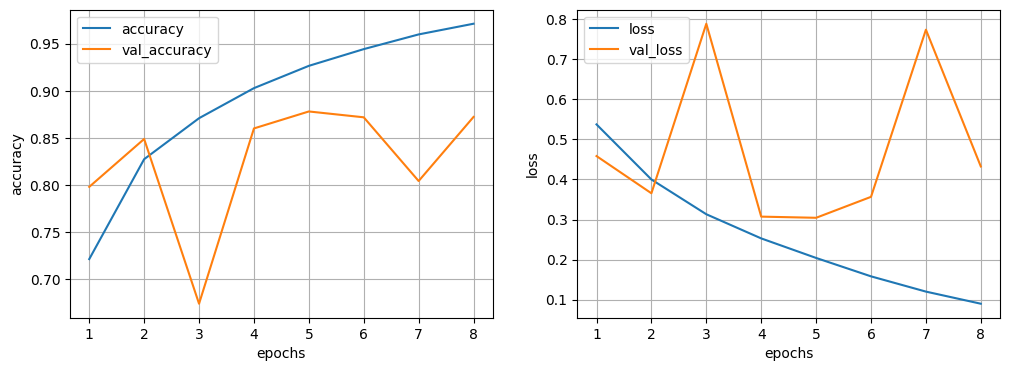

In [20]:
# 여섯 번째 검증 세트의 손실은 올라가고, 정확도는 감소한다.
#   - 그 이후 세 번의 에포크 동안 검증 손실이 개선되지 않으므로 훈련이 조기종료
epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# 정확도 그래프
axs[0].plot(epochs, hist.history['accuracy'], label='accuracy')
axs[0].plot(epochs, hist.history['val_accuracy'], label='val_accuracy')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()
axs[0].grid()

# 손실 그래프
axs[1].plot(epochs, hist.history['loss'], label='loss')
axs[1].plot(epochs, hist.history['val_loss'], label='val_loss')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].legend()
axs[1].grid()

plt.show()

In [23]:
classifier.predict([feature])

2025-10-04 12:46:29.727769: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 88 bytes spill stores, 88 bytes spill loads

2025-10-04 12:46:29.777382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 400 bytes spill stores, 400 bytes spill loads

2025-10-04 12:46:29.837662: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 432 bytes spill stores, 336 bytes spill loads

2025-10-04 12:46:29.941431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 424 bytes spill stores, 352 bytes spill loads

2025-10-04 12:46:30.076583: I external/loc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


array([[0.54843545]], dtype=float32)

In [24]:
classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8695 - loss: 0.3323


[0.33228516578674316, 0.8694800138473511]

### Chapter 4 텍스트 전처리하기 - BERT 토크나이져 <a class="anchor" id="chapter4"></a>
1. 토큰화(Tokenization)
   - 텍스트 데이터를 모델에 입력하기 위해 단어, 부분 단어, 문자 등으로 분할하는 과정
   - 보통 하나의 단어가 한 개 이상의 토큰에 대응된다.
   - 고유한 토큰의 집합을 어휘사전(Vocabulary)이라고 부른다.
   - 모델은 어휘사전을 바탕으로 새로운 텍스트를 토큰으로 분할하기 때문에 토크나이져와 어휘사전이 모델의 성능에 큰 영향을 미친다.

2. 인공 신경망에서는 토큰을 고정된 길이의 실수 벡터로 표현하는 임베딩 벡터를 주로 사용한다.

2. BERT 모델의 토큰화
   - BERT 모델에서는 WordPiece 토크나이저를 사용
   - 워드피스 토큰화(wordpiece tokenization)는 단어를 더 작은 단위의 단어로 분리하는 부분단어 토큰화(Subword Tokenization) 방법중 하나이다.
   - WordPiece 토크나이저는 자주 등장하는 단어를 우선적으로 토큰으로 분할하고, 드물게 등장하는 단어는 더 작은 단위로 분할
   - WordPiece 토크나이저는 어휘 사전에 없는 단어도 부분 단어로 분할하여 처리할 수 있어, 희귀 단어에 대한 대응력이 뛰어나다.
   - 부분단어의 빈도를 개별 토큰의 빈도로 나눈 점수를 계산하고, 이 점수가 높은 부분단어를 어휘사전에 추가
   - 말뭉치에 등장하는 빈도 10:ng, 15:de를 어휘사전에 추가
      - BEP 토큰화: 에서는 등장 빈도가 높은 'de'가 먼저 어휘사전에 추가
      - WordPice 토큰화: 'ng'를 구성하는 'n'과 'g', 'de'를 구성하는 'd'와'e'의 빈도를 고려해 점수를 계산
         - 'n,g,d,e' 네 문자의 빈도가 가각 12, 16, 20, 30이라고 할 때, 다음과 같이 계산한다. 
            - 'ng'의 점수: 10 / 12*16 = 0.052
            - 'de'의 점수: 15 / 20*16 = 0.025 
         - 'ng'의 점수가 더 높기 때문에 'ng'가 먼저 어휘사전에 추가

In [ ]:
print(feature)
prep_data = classifier.preprocessor(feature)

# 512: token_ids의 길이
print(len(prep_data['token_ids']))

# 0 ~ 10: token_ids의 처음 10개 값
print(prep_data['token_ids'][:10])

tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
512
tf.Tensor([  101  1000  6090  3207 26387  1000  2003  1037  5469  3185], shape=(10,), dtype=int32)


In [ ]:
# 샘플의 길이가 512보다 작기 때문에 0 패딩이 추가되어 있다.
prep_data['token_ids'][-10:]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
# 분류 문제이므로 입력 텍스트에서 문장을 구분할 필요없다.
prep_data['segment_ids']

<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [ ]:
# 토큰이 있는 자리는 1, 그외의 모든 자리는 0
#    - sum()함수를 사용해 1의 개수를 더하면 샘플 시퀸스의 길이가된다.
sum(prep_data['padding_mask'].numpy())

np.int64(197)

In [ ]:
bert_tokenizer = classifier.preprocessor.tokenizer

# detokenize() 함수를 사용해 토큰을 원래의 텍스트로 복원
#   - 10개의 토큰 아이디를 전달했는데, 8개의 토큰이 복원되었다.
#   - 일부 단어가 여러 개의 부분단어로 나누어져 토큰 아이디가 각각 할당되었다
bert_tokenizer.detokenize(prep_data['token_ids'][:10]) 

'[CLS] " pandemonium " is a horror movie'

In [ ]:
# pandemonium가 세 개의 단어로 나누졌다.
#   - ## : 부분 단어임을 나타내는 접두사
tokens = []
for id in prep_data['token_ids'][:10]:
    tokens.append(bert_tokenizer.id_to_token(id))
print(tokens)

['[CLS]', '"', 'pan', '##de', '##monium', '"', 'is', 'a', 'horror', 'movie']


### Chapter 5 허깅페이스로 영화 리뷰 텍스트의 감성 분류하기 <a class="anchor" id="chapter5"></a>
1. 허깅페이스(Hugging Face)
   - 자연어 처리 분야에서 널리 사용되는 오픈소스 라이브러리
   - 다양한 사전 훈련된 모델과 토크나이저를 제공
   - 트랜스포머(Transformers) 라이브러리를 통해 BERT, GPT, T5 등 다양한 모델을 쉽게 사용할 수 있다.
   - 허깅페이스는 모델 허브(Model Hub)를 통해 수많은 사전 훈련된 모델을 공유하고 다운로드할 수 있는 플랫폼을 제공
   - 허깅페이스의 토크나이저는 다양한 토큰화 방법을 지원하며, 모델에 맞는 토크나이저를 자동으로 선택할 수 있다.
   - 허깅페이스는 파이프라인(Pipeline) 기능을 통해 텍스트 분류, 감성 분석, 질문 답변 등 다양한 자연어 처리 작업을 간단한 코드로 수행할 수 있다.
   - 허깅페이스는 커뮤니티 중심의 개발이 이루어지며, 사용자들이 직접 모델과 데이터를 공유하고 협업할 수 있는 환경을 제공한다.

2. 네이버 영화 리뷰 데이터셋
   - 네이버 영화 리뷰 데이터셋은 한국어 영화 리뷰 데이터를 포함하는 공개 데이터셋
   - 긍정(1)과 부정(0)으로 라벨링된 리뷰 텍스트로 구성
   - 감성 분석(Sentiment Analysis) 작업에 자주 사용
   - https://huggingface.co/ 접속
      - 검색창에 'naver movie review dataset' 입력
      - 'e9t / nsmc' 클릭 후 상세 페이지로 이동

3. 허깅페이스 라이브러리 설치
    - 훈련 데이터를 위한 datasets / 모델 훈련을 위한 accelerate / 모델 평가를 위한 evaluate
    - pip install transformers datasets evaluate accelerate

In [ ]:
from datasets import load_dataset

# 허깅페이스에서 제공하는 IMDB 데이터셋 로드
nsmc = load_dataset("Blpeng/nsmc")

Repo card metadata block was not found. Setting CardData to empty.
Generating test split: 100%|██████████| 50000/50000 [00:00<00:00, 576419.37 examples/s]


In [ ]:
# nsmc 변수는 DatasetDict 클래스의 객체.
#   - features: 데이터셋의 특징(컬럼) 정보
#   - num_rows: 각 데이터셋의 샘플 수
#   - train, test: 훈련 데이터셋과 테스트 데이터셋
print(nsmc)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# label: 0(부정적인 감성), 1(긍정적인 감성)
# document: 영화 리뷰 텍스트
# 훈련 데이터셋의 샘플 1개 출력
nsmc['train'][0]

{'Unnamed: 0': 0, 'id': 9976970, 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}

4. 허깅페이스에서 한글 데이터로 훈련한 bert_small 모델 찾기
   - https://huggingface.co/ 접속
   - 검색창에 'bert kor small' 입력
   - 'bongsoo/bert-small-kor-v1 ' 클릭 후 상세 페이지로 이동
   - AutoModelForSequenceClassification를 사용해 transformers 라이브러리로 사전 훈련된 백본 모델 로드

In [7]:
# 불필요한 열 삭제 및 누락된 데이터 삭제
from datasets import DatasetDict

nsmc = nsmc.map(remove_columns=["Unnamed: 0"])
nsmc = DatasetDict({
    split: nsmc[split].filter(lambda x: x['document'] and x['document'].strip())
    for split in nsmc})

Filter: 100%|██████████| 50000/50000 [00:00<00:00, 481058.85 examples/s]


In [8]:
print(nsmc)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 49997
    })
})


In [9]:
from transformers import AutoModelForSequenceClassification

bert_kor = AutoModelForSequenceClassification.from_pretrained("bongsoo/bert-small-kor-v1", num_labels=2)

2025-10-04 22:05:33.071904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759583133.139165     945 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759583133.159437     945 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759583133.297407     945 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759583133.297434     945 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759583133.297436     945 computation_placer.cc:177] computation placer alr

In [10]:
print(bert_kor)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10022, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-1

In [11]:
from transformers import AutoTokenizer

# 허깅페이스에서 제공하는 AutoTokenizer를 사용해 토크나이저 로드
#   - bert-small-kor-v1 : 한국어 소형 BERT 모델
bert_kor_tokenizer = AutoTokenizer.from_pretrained("bongsoo/bert-small-kor-v1")

In [12]:
print(nsmc['train'][0]['document'])

pre_data = bert_kor_tokenizer([nsmc['train'][0]['document']])
print(pre_data.keys())  # 토큰 아이디, 어텐션 마스크, 토큰 타입 아이디

아 더빙.. 진짜 짜증나네요 목소리
KeysView({'input_ids': [[2, 606, 261, 1519, 17, 17, 4668, 766, 1400, 1132, 1464, 1130, 2889, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]})


In [ ]:
# 입력 데이터의 토큰 아이디 확인
pre_data['input_ids']

[[2, 606, 261, 1519, 17, 17, 4668, 766, 1400, 1132, 1464, 1130, 2889, 3]]

In [16]:
tokens = bert_kor_tokenizer.convert_ids_to_tokens(pre_data['input_ids'][0])
print(tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜', '##증', '##나', '##네', '##요', '목소리', '[SEP]']


In [17]:
bert_kor_tokenizer.convert_tokens_to_string(tokens)

'[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'

In [45]:
# 배치 데이터가 전달되면 bert_kor_tokenizer를 사용해 'document' 속성에 있는 문자열 전처리
#def tokenize(batch):   
    # padding=True : 배치에 있는 가장 길이가 긴 샘플에 맞춰 짧은 샘플에 패딩 추가
    # truncation=True : 샘플이 최대 길이를 초과하면 자름
    #return bert_kor_tokenizer(batch['document'], padding=True, truncation=True)

def tokenize(batch):
    # padding="max_length" : 모든 샘플을 max_length로 패딩
    # max_length=160 : 모델의 최대 입력 길이에 맞춤
    # truncation=True : 샘플이 최대 길이를 초과하면 자름
    return bert_kor_tokenizer(batch['document'], padding="max_length", max_length=160, truncation=True)

In [46]:
nsmc_tokenized = nsmc.map(tokenize, batched=True, batch_size=32)

# input_ids, attention_mask, token_type_ids 속성이 추가된 것을 확인할 수 있다.
print(nsmc_tokenized)

Map: 100%|██████████| 49997/49997 [00:05<00:00, 8640.31 examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49997
    })
})


In [47]:
# 전체 훈련은 오래걸리므로, 훈련된 모델을 사용하는 방법만 알아보기 위해 일부만 사용
#   - shuffle(seed=42) : 샘플을 무작위로 섞음
nsmc_train = nsmc_tokenized["train"].shuffle(seed=42).select(range(1000))
nsmc_test = nsmc_tokenized["test"].shuffle(seed=42).select(range(100))

5. BERT 모델 미세 튜닝
    - transformers 라이브러리로 모델을 훈련하려면 모델의 성능을 평가하는 함수를 정의해서 전달해야한다.
    - 허깅페이스에서 평가 지표를 위한 evaluate 라이브러리를 제공

In [48]:
import evaluate

# evaluate 라이브러리를 사용해 정확도 측정
#   - accuracy : 정확도 측정 지표
metric = evaluate.load("accuracy")

import numpy as np

# 모델의 훈련 과정에서 에포크가 끝날 때마다 검증 데이터셋의 정확도를 계산하기 위해 호출된다.
#def compute_metrics(eval_pred):
    # eval_pred: (예측값, 실제값) 튜플
    #    - logits: 모델이 예측한 값, shape(배치 크기, 클래스 개수)
    #    - labels: 실제 레이블, shape(배치 크기,)
    #logits, labels = eval_pred
    # argmax(axis=-1): 가장 큰 값의 인덱스를 반환, 즉 0 또는 1
 #   predictions = np.argmax(logits, axis=-1)
 #   return metric.compute(predictions=predictions, references=labels)
 
def compute_metrics(eval_pred):
    # (100, 2), (100,)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [49]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="bert_kor_nsmc", # 훈련된 모델과 체크포인트를 저장할 디렉터리
    num_train_epochs=5,         # 훈련에 사용할 에포크 수
    save_strategy="epoch",  # 에포크가 끝날 때마다 모델 저장
    eval_strategy="epoch", # 에포크가 끝날 때마다 평가
    logging_steps=len(nsmc_train) // 8, # 1 에포크 동안 로깅하는 횟수
    load_best_model_at_end=True, # 가장 성능이 좋은 모델을 훈련이 끝난 후에 불러옴
    report_to="none", # 훈련 과정에서 생성되는 로그를 저장하지 않음
)

In [ ]:
trainer = Trainer(model=bert_kor,
                  train_dataset=nsmc_train,
                  eval_dataset=nsmc_test,
                  args=training_args,
                  compute_metrics=compute_metrics)
# 훈련된 모델을 사용하기 때문에 몇 번의 에포크만에 정확도 80%에 도달한다.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.610200,0.500490,0.730000
2,0.414900,0.556795,0.790000
3,0.276900,0.536554,0.780000
4,0.147000,0.764148,0.800000
5,0.108900,0.768724,0.790000


TrainOutput(global_step=625, training_loss=0.3115909194946289, metrics={'train_runtime': 16.175, 'train_samples_per_second': 309.119, 'train_steps_per_second': 38.64, 'total_flos': 61796361600000.0, 'train_loss': 0.3115909194946289, 'epoch': 5.0})

In [ ]:
preds_output = trainer.predict(nsmc_test)

print(preds_output.predictions[:7])  # 모델이 예측한 값(로짓)
print(preds_output.label_ids[:7])    # 실제 레이블